In [1]:
library(rcompanion)
library(tidyverse)
library(reshape2)
library(janitor)
library(rstatix)
library(ggpubr)
library(FSA)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.tes

In [2]:
C5_cluster_raw <- read.csv("C5_clusterCO2_6clusters.csv") |>
                  janitor::clean_names()
colnames(C5_cluster_raw)

[1] "study"                       "co"                         
 [3] "h2"                          "inert"                      
 [5] "reactor_pressure_bar"        "reaction_temp_o_c"          
 [7] "space_velocity_m_l_h"        "mass_of_catalyst"           
 [9] "dilution"                    "calcination_temperature"    
[11] "calcination_time"            "reduction_temperature"      
[13] "reduction_time_hr"           "bet_surface"                
[15] "pore_volume"                 "pore_daimeter_nm"           
[17] "crystallite_size"            "co2_upatke"                 
[19] "first_peak"                  "last_reduction_peak_tpr"    
[21] "al"                          "ba"                         
[23] "ca"                          "ce"                         
[25] "co_2"                        "cu"                         
[27] "fe"                          "mg"                         
[29] "ni"                          "pb"                         
[31] "ti"                          "zn"                         
[33] "zr"                          "c"                          
[35] "n"                           "o"                          
[37] "cs"                          "ga"                         
[39] "in"                          "k"                          
[41] "la"                          "li"                         
[43] "mn"                          "mo"                         
[45] "na"                          "rb"                         
[47] "ru"                          "w"                          
[49] "y"                           "support"                    
[51] "co_1"                        "co_h2"                      
[53] "h2_1"                        "co_precipitation"           
[55] "deposition_precipitation"    "impregnation"               
[57] "physical_mixing"             "pyrolysis"                  
[59] "sol_gel"                     "solvothermal_method"        
[61] "urea_self_combustion_method" "ac"                         
[63] "al2o3"                       "cnt"                        
[65] "ce_o2"                       "mg_o"                       
[67] "si_c"                        "si_o2"                      
[69] "ti_o2"                       "zr_o2"                      
[71] "mixed_oxides"                "nosupport"                  
[73] "zeolite"                     "co2_conversion"             
[75] "co_sel"                      "ch4_sel"                    
[77] "c2_c4"                       "c5"                         
[79] "o_p_ratio"                   "cluster"

In [3]:
response_vars <- c("co2_conversion","co_sel","ch4_sel", "c2_c4","c5","o_p_ratio")

In [4]:
#Select our columns of interest only
C5_cluster_data <- C5_cluster_raw |>  
                   dplyr::select(all_of(c(response_vars, "cluster"))) |>
                   dplyr::mutate(cluster = factor(cluster))
head(C5_cluster_data)

,co2_conversion,co_sel,ch4_sel,c2_c4,c5,o_p_ratio,cluster
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,24.05,26.20,20.91,40.97,11.91,0.8710000,1
2,27.53,18.57,18.66,45.91,16.86,1.6960000,1
3,23.08,37.98,16.17,35.95,9.89,1.2340000,1
4,18.79,53.39,12.94,25.37,8.31,1.5630000,1
5,16.83,59.33,13.53,21.91,5.23,0.9070000,1
6,24.05,26.20,20.91,40.97,11.91,0.8712504,1


In [5]:
#compare_cluster_sizes
(cluste_counts <-  C5_cluster_data |> 
                  dplyr::group_by(cluster) |>
                  dplyr::count())
                 

cluster,n
<fct>,<int>
1,10
2,37
3,95
4,80
5,47
6,105


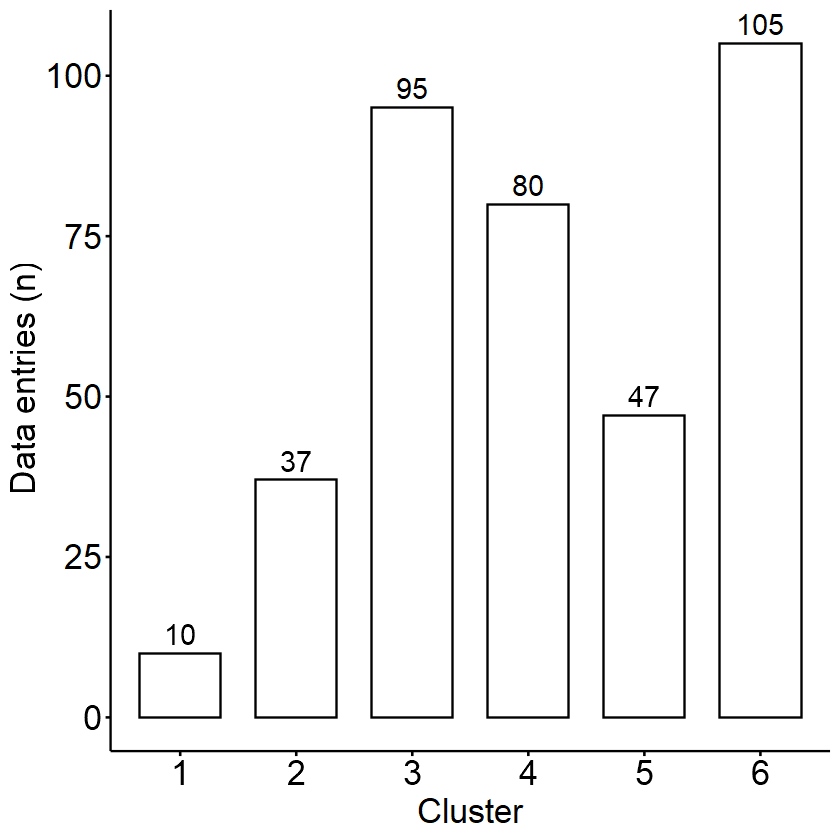

In [6]:
counts_plots <-  ggbarplot(cluste_counts, 
                      x = "cluster",  
                      y =  "n", 
                      lab.size = 6,
                      label = TRUE,
                      xlab = "Cluster", 
                      ylab = "Data entries (n)") + 
            theme(axis.title.x = element_text(size = 20), 
      axis.title.y = element_text(size = 20), 
      axis.text.x = element_text(size = 20),  
      axis.text.y = element_text(size = 20)) 

counts_plots

In [7]:
#convert the data into wide format
cluster_melted <- C5_cluster_data |> 
                  reshape2::melt()

head(cluster_melted)

Using cluster as id variables



,cluster,variable,value
,<fct>,<fct>,<dbl>
1,1,co2_conversion,24.05
2,1,co2_conversion,27.53
3,1,co2_conversion,23.08
4,1,co2_conversion,18.79
5,1,co2_conversion,16.83
6,1,co2_conversion,24.05


In [8]:
#Missing data for o_p_ratio
(cluster_melted_NA <- cluster_melted |> 
                     dplyr::filter(is.na(value)) |>
                     dplyr::group_by(cluster, variable) |>
                     dplyr::count())

cluster,variable,n
<fct>,<fct>,<int>
2,o_p_ratio,6
3,o_p_ratio,21
4,o_p_ratio,7
5,o_p_ratio,13
6,o_p_ratio,16


In [9]:
sum(cluster_melted_NA$n)

[1] 63

In [10]:
dput(unique(cluster_melted$variable))

structure(1:6, levels = c("co2_conversion", "co_sel", "ch4_sel", 
"c2_c4", "c5", "o_p_ratio"), class = "factor")


In [11]:
variable_labels <- c(co2_conversion = "CO[2]~conversion",
                     co_sel = "CO~selectivity",
                     ch4_sel = "CH[4]~selectivity",
                     c2_c4 = "C[2]-C[4]",
                     c5 = "phantom() >=C[5]",
                     o_p_ratio = "O/P~ratio")

In [12]:
variable_labels

co2_conversion              co_sel             ch4_sel               c2_c4 
 "CO[2]~conversion"    "CO~selectivity" "CH[4]~selectivity"         "C[2]-C[4]" 
                 c5           o_p_ratio 
 "phantom() >=C[5]"         "O/P~ratio"

In [13]:
#dput(cluster_melted$variable)

In [14]:
cluster_melted$variable <- factor(cluster_melted$variable, levels = c("co2_conversion", "co_sel", "ch4_sel", "c2_c4", "c5", "o_p_ratio"))

Warning message:
"Removed 63 rows containing non-finite outside the scale range (`stat_boxplot()`)."


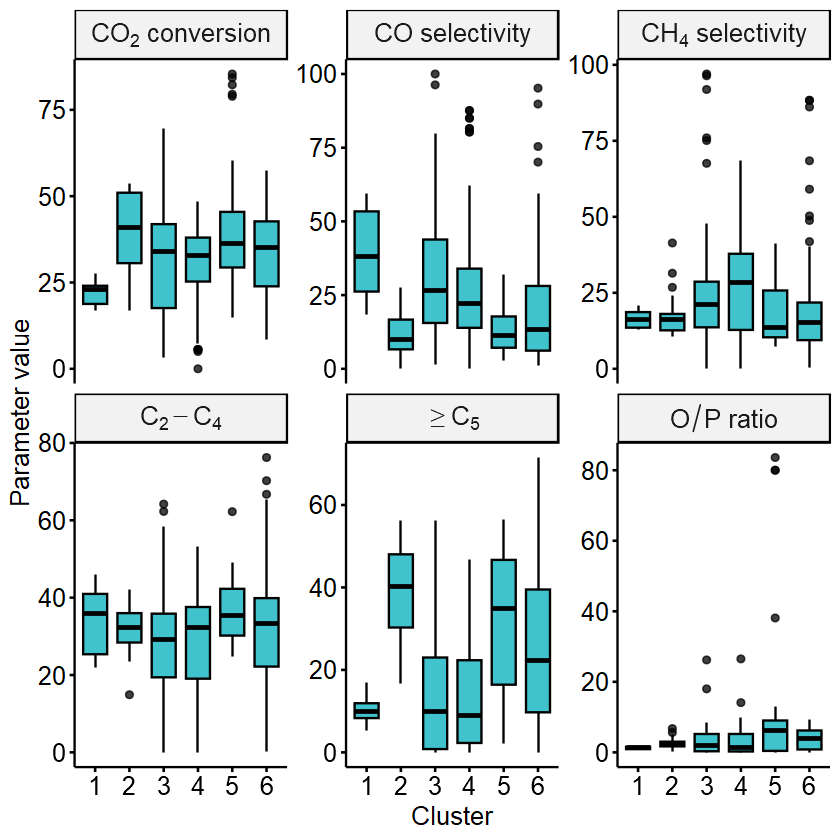

In [15]:
p1 <-  ggboxplot(cluster_melted,
          x = "cluster", 
          y = "value",
          xlab = "Cluster", 
          ylab = "Parameter value",
          alpha = 0.75,
          fill = "#00AFBB") + 
          facet_wrap(~variable, scales = "free_y", labeller=as_labeller(variable_labels, label_parsed)) +
   theme(strip.text = element_text(size = 15),
                  axis.title.x = element_text(size = 15), 
                  axis.title.y = element_text(size = 15), 
                  axis.text.x = element_text(size = 15),
                  axis.text.y = element_text(size = 15))
p1

In [16]:
Kruskal_Wallis_results <- lapply(response_vars, function(col){
    
         kruskal_results <-  kruskal.test(C5_cluster_data[[col]], C5_cluster_data$cluster)
         data.frame(Response_var = col,
         statistic = kruskal_results$statistic, 
         df = kruskal_results$parameter[['df']], 
         p = kruskal_results$p.value,  
         method = kruskal_results$method)
    
})

#Kruskal_Wallis_results
do.call(rbind, Kruskal_Wallis_results)

,Response_var,statistic,df,p,method
,<chr>,<dbl>,<int>,<dbl>,<chr>
Kruskal-Wallis chi-squared,co2_conversion,26.46821,5,7.238476e-05,Kruskal-Wallis rank sum test
Kruskal-Wallis chi-squared1,co_sel,79.71897,5,9.608279e-16,Kruskal-Wallis rank sum test
Kruskal-Wallis chi-squared2,ch4_sel,23.75335,5,2.421324e-04,Kruskal-Wallis rank sum test
Kruskal-Wallis chi-squared3,c2_c4,15.21729,5,9.473132e-03,Kruskal-Wallis rank sum test
Kruskal-Wallis chi-squared4,c5,96.41249,5,3.011302e-19,Kruskal-Wallis rank sum test
Kruskal-Wallis chi-squared5,o_p_ratio,17.62226,5,3.459051e-03,Kruskal-Wallis rank sum test


In [17]:
#This is hack to force the clusters to be ranked based on means
tag_names<- cluster_melted |>
            dplyr::group_by(cluster, variable) |>
            dplyr::summarise(ymax = max(value, na.rm = TRUE), ymean = max(value, na.rm = TRUE)) |>
            dplyr::mutate(cluster_tag = glue::glue("c{cluster}_{variable}_{ymean}"))

`summarise()` has grouped output by 'cluster'. You can override using the `.groups` argument.


In [18]:
dim(cluster_melted)

[1] 2244    3

In [19]:
head(tag_names)

cluster,variable,ymax,ymean,cluster_tag
<fct>,<fct>,<dbl>,<dbl>,<glue>
1,co2_conversion,27.530000,27.530000,c1_co2_conversion_27.53
1,co_sel,59.330000,59.330000,c1_co_sel_59.33
1,ch4_sel,20.910000,20.910000,c1_ch4_sel_20.91
1,c2_c4,45.910000,45.910000,c1_c2_c4_45.91
1,c5,16.860000,16.860000,c1_c5_16.86
1,o_p_ratio,1.696318,1.696318,c1_o_p_ratio_1.696317551


In [20]:
get_dunn <- function(col){

        subset_dat <- C5_cluster_data |> dplyr::select(all_of(c(col, "cluster")))
    
        for (clust_id in  unique(subset_dat$cluster)){
             cluster_median <- round(median(subset_dat[subset_dat$cluster == clust_id,col],  na.rm = TRUE), 1)
             subset_dat[subset_dat$cluster == clust_id,"cluster_median"] <- cluster_median }
        
        subset_dat_ranked <- subset_dat |>
                             dplyr::group_by(cluster_median) |>
                             dplyr::mutate(cluster_rank = cur_group_id()) |>
                             dplyr::ungroup() |>
                             dplyr::mutate(Group = as.factor(glue::glue("c_rank_{cluster_rank}_{cluster_median}_C{cluster}"))) 

        ranked <- dplyr::distinct(subset_dat_ranked[c("cluster", "Group")])
        ranked$cluster <- factor(ranked$cluster, levels = ranked$cluster)
        #Pairwise Dunn Test to find out which clusters is higher
        posthoc_dunn <- FSA::dunnTest(subset_dat_ranked[[col]], subset_dat_ranked$Group, method = "bonferroni")
        cld <- cldList(comparison = posthoc_dunn$res$Comparison,  p.value = posthoc_dunn$res$P.adj, threshold = 0.05, remove.zero = FALSE) |>
               dplyr::left_join(ranked) |>
               dplyr::mutate(variable = col) |>
               dplyr::mutate(rank = rank(MonoLetter, ties.method = "min")) |>
               dplyr::select(Group, Letter, MonoLetter,	cluster, variable, rank) |>
               dplyr::arrange(rank)

 return(cld)
    
}


In [21]:
DunnTest_results <- lapply(response_vars, get_dunn)

Joining with `by = join_by(Group)`
Joining with `by = join_by(Group)`
Joining with `by = join_by(Group)`
Joining with `by = join_by(Group)`
Joining with `by = join_by(Group)`
Warning message:
"Some rows deleted from 'x' and 'g' because missing data."
Joining with `by = join_by(Group)`


In [22]:
head(tag_names)

cluster,variable,ymax,ymean,cluster_tag
<fct>,<fct>,<dbl>,<dbl>,<glue>
1,co2_conversion,27.530000,27.530000,c1_co2_conversion_27.53
1,co_sel,59.330000,59.330000,c1_co_sel_59.33
1,ch4_sel,20.910000,20.910000,c1_ch4_sel_20.91
1,c2_c4,45.910000,45.910000,c1_c2_c4_45.91
1,c5,16.860000,16.860000,c1_c5_16.86
1,o_p_ratio,1.696318,1.696318,c1_o_p_ratio_1.696317551


In [23]:
(signif_letters <- do.call(rbind, DunnTest_results) |>
                   left_join(tag_names) |>
dplyr::arrange(variable, rank))

Joining with `by = join_by(cluster, variable)`


Group,Letter,MonoLetter,cluster,variable,rank,ymax,ymean,cluster_tag
<chr>,<chr>,<chr>,<fct>,<chr>,<int>,<dbl>,<dbl>,<glue>
c_rank_5_35.4_C5,b,b,5,c2_c4,1,62.240000,62.240000,c5_c2_c4_62.24
c_rank_1_29.2_C3,a,a,3,c2_c4,2,64.200000,64.200000,c3_c2_c4_64.2
c_rank_2_32.2_C4,ab,ab,4,c2_c4,3,53.200000,53.200000,c4_c2_c4_53.2
c_rank_3_32.3_C2,ab,ab,2,c2_c4,3,42.000000,42.000000,c2_c2_c4_42
c_rank_4_33.4_C6,ab,ab,6,c2_c4,3,76.240000,76.240000,c6_c2_c4_76.24
c_rank_6_36_C1,ab,ab,1,c2_c4,3,45.910000,45.910000,c1_c2_c4_45.91
c_rank_5_40.3_C2,d,d,2,c5,1,56.340000,56.340000,c2_c5_56.34
c_rank_4_34.8_C5,cd,cd,5,c5,2,56.360000,56.360000,c5_c5_56.36
c_rank_3_22.2_C6,bc,bc,6,c5,3,71.510000,71.510000,c6_c5_71.51


Warning message:
"Removed 63 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 63 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 63 rows containing non-finite outside the scale range (`stat_boxplot()`)."


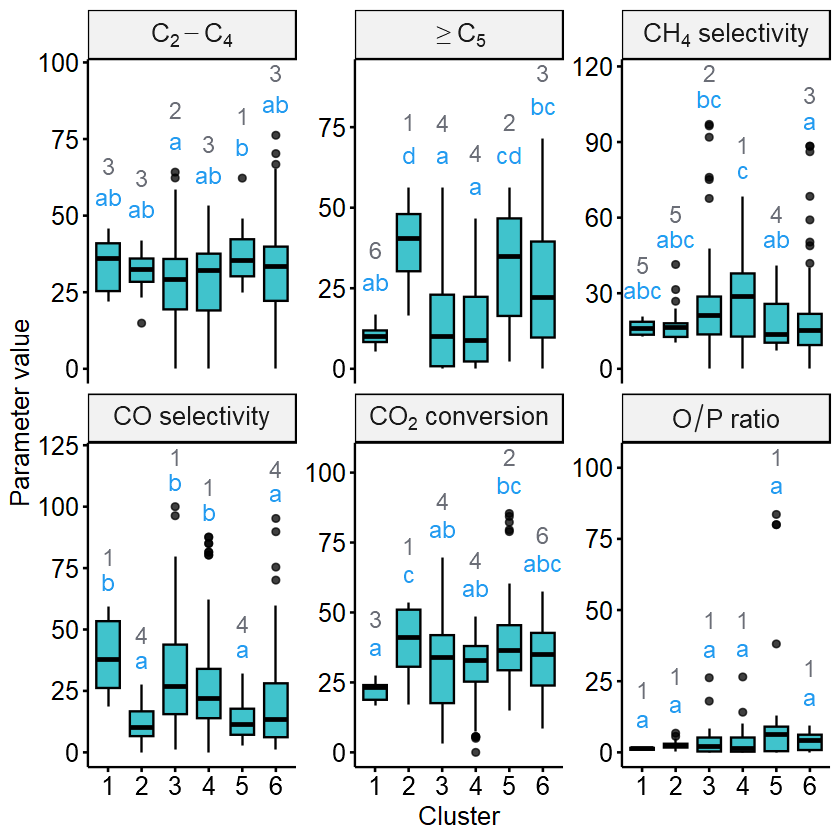

In [24]:
#plots available in plots folder
p1 + 
geom_text(data = signif_letters, aes(x = cluster, y = ymax + 10, label = Letter), size = 5, colour ="#239bf0") +
geom_text(data = signif_letters, aes(x = cluster, y = ymax + 20, label = rank), size = 5, colour = "#6b6e77" ) 

ggsave("plots/var_distributions.pdf", width = 8, height = 8)
ggsave("plots/var_distributions.png", width = 8, height = 8)

In [25]:
head(signif_letters)

,Group,Letter,MonoLetter,cluster,variable,rank,ymax,ymean,cluster_tag
,<chr>,<chr>,<chr>,<fct>,<chr>,<int>,<dbl>,<dbl>,<glue>
1,c_rank_5_35.4_C5,b,b,5,c2_c4,1,62.24,62.24,c5_c2_c4_62.24
2,c_rank_1_29.2_C3,a,a,3,c2_c4,2,64.20,64.20,c3_c2_c4_64.2
3,c_rank_2_32.2_C4,ab,ab,4,c2_c4,3,53.20,53.20,c4_c2_c4_53.2
4,c_rank_3_32.3_C2,ab,ab,2,c2_c4,3,42.00,42.00,c2_c2_c4_42
5,c_rank_4_33.4_C6,ab,ab,6,c2_c4,3,76.24,76.24,c6_c2_c4_76.24
6,c_rank_6_36_C1,ab,ab,1,c2_c4,3,45.91,45.91,c1_c2_c4_45.91


In [26]:
(Cluster_rankings <- signif_letters |>
                    dplyr::select(variable, cluster, rank) |>
                    tidyr::pivot_wider(names_from = variable, values_from = rank) |>
                    dplyr::arrange(cluster))

cluster,c2_c4,c5,ch4_sel,co2_conversion,co_sel,o_p_ratio
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,3,6,5,3,1,1
2,3,1,5,1,4,1
3,2,4,2,4,1,1
4,3,4,1,4,1,1
5,1,2,4,2,4,1
6,3,3,3,6,4,1


In [27]:
(cluster_long_df <-  Cluster_rankings |>
                 gather(key = "response_variable", 
                 value = "ranking",  
                 c2_c4,	c5,	ch4_sel,co2_conversion,	co_sel, o_p_ratio))

cluster,response_variable,ranking
<fct>,<chr>,<int>
1,c2_c4,3
2,c2_c4,3
3,c2_c4,2
4,c2_c4,3
5,c2_c4,1
6,c2_c4,3
1,c5,6
2,c5,1
3,c5,4


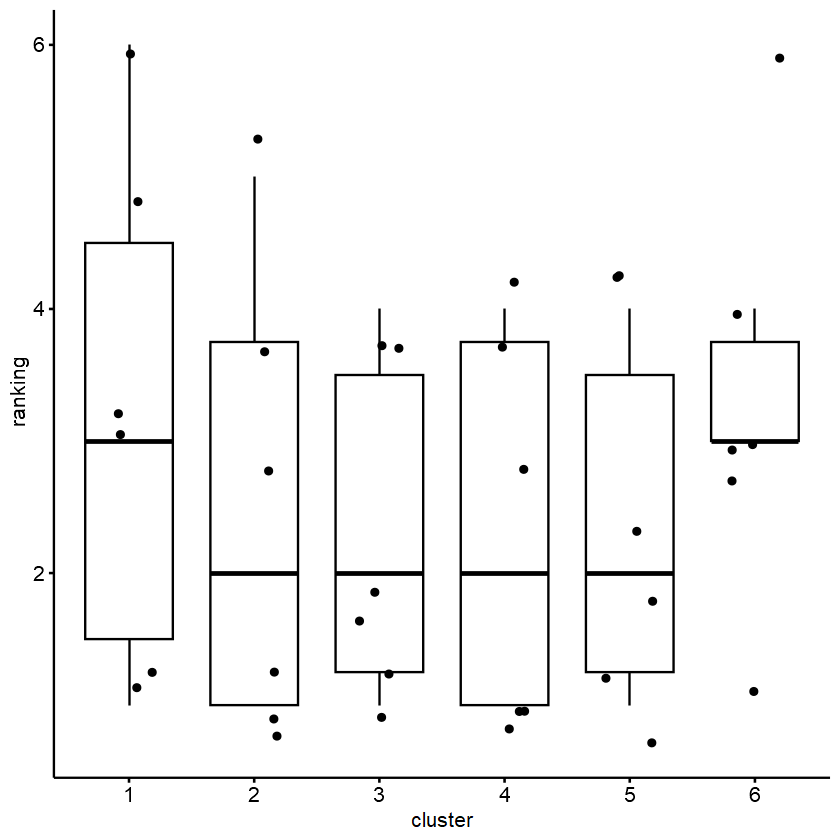

In [28]:
ggboxplot(cluster_long_df, x = "cluster", y = "ranking", add = "jitter")

In [29]:
(res_friedman <- cluster_long_df |> 
                 friedman_test(ranking ~  response_variable|cluster))

,.y.,n,statistic,df,p,method
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Friedman chi-squared,ranking,6,10.37037,5,0.0653959,Friedman test


In [30]:
Cluster_rankings |>
dplyr::mutate(cluster = glue::glue("cluster_{cluster}")) |>
tibble::column_to_rownames(var = "cluster") |>
dplyr::mutate(total_rank = rowSums(across(where(is.numeric)))) |>
dplyr::arrange(total_rank)

,c2_c4,c5,ch4_sel,co2_conversion,co_sel,o_p_ratio,total_rank
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
cluster_3,2,4,2,4,1,1,14
cluster_4,3,4,1,4,1,1,14
cluster_5,1,2,4,2,4,1,14
cluster_2,3,1,5,1,4,1,15
cluster_1,3,6,5,3,1,1,19
cluster_6,3,3,3,6,4,1,20
